Hier werden die Daten aus Yahoo Finance heruntergeladen, bearbeitet und abschließend beschrieben. Die Transformationen der Daten haben aus Gründen der Verifizierbarkeit und Sichtbarkeit parallel auch in Microsoft Excel über Funktionen und VBA stattgefunden - das Ergebnis ist identisch.

## Importe

In [1]:
#Import der notwendigen Bibliotheken, Installation mit pip bereits erfolgt

import yfinance as yf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import csv

## Herunterladen der Daten

#### JSE

In [10]:
df_one = pd.read_csv(
    "WhartonJSE1.csv",
    sep=";",              
    decimal=",",          
    parse_dates=["Date"], 
    index_col="Date"       
)

In [11]:
df_two = pd.read_csv(
    "WhartonJSE2.csv",
    sep=";",               
    decimal=",",           
    parse_dates=["Date"],  
    index_col="Date"       
)

In [12]:
df_combined = pd.concat([df_one, df_two], axis=0)
df_combined.head

<bound method NDFrame.head of              8303  15604   15618  15621   15781  15885  16179  16183  16291  \
Date                                                                          
01.06.2005  39.00  62.11   74.50  22.20   61.40   12.0  14.50   8.60   4.42   
02.06.2005  38.80  62.00   75.00  22.08   62.00    NaN  14.51   8.51   4.40   
03.06.2005    NaN  60.79   75.64  22.00   64.56    NaN  14.50   8.50   4.37   
06.06.2005    NaN  60.75   78.49  22.01   65.70    NaN  13.85   8.62   4.38   
07.06.2005  36.11  60.90   77.90  22.05   66.00   12.0  13.89   8.67   4.43   
...           ...    ...     ...    ...     ...    ...    ...    ...    ...   
26.05.2025    NaN    NaN  256.98    NaN  228.71    NaN    NaN  12.95    NaN   
27.05.2025    NaN    NaN  255.97    NaN  227.60    NaN    NaN  13.08    NaN   
28.05.2025    NaN    NaN  257.02    NaN  231.68    NaN    NaN  13.10    NaN   
29.05.2025    NaN    NaN  259.83    NaN  235.09    NaN    NaN  13.32    NaN   
30.05.2025    NaN    N

In [13]:
df_combined.to_csv("wharton_debug1.csv")

In [14]:
#Zuerst alle Zeilen entfernen, die nur NaN enthalten
df_combined = df_combined.dropna(axis=0, how='all')

#Dann alle Spalten entfernen, die nur NaN enthalten
df_combined = df_combined.dropna(axis=1, how='all')

df_combined.head

<bound method NDFrame.head of              8303  15604   15618  15621   15781  15885  16179  16183  16291  \
Date                                                                          
01.06.2005  39.00  62.11   74.50  22.20   61.40   12.0  14.50   8.60   4.42   
02.06.2005  38.80  62.00   75.00  22.08   62.00    NaN  14.51   8.51   4.40   
03.06.2005    NaN  60.79   75.64  22.00   64.56    NaN  14.50   8.50   4.37   
06.06.2005    NaN  60.75   78.49  22.01   65.70    NaN  13.85   8.62   4.38   
07.06.2005  36.11  60.90   77.90  22.05   66.00   12.0  13.89   8.67   4.43   
...           ...    ...     ...    ...     ...    ...    ...    ...    ...   
26.05.2025    NaN    NaN  256.98    NaN  228.71    NaN    NaN  12.95    NaN   
27.05.2025    NaN    NaN  255.97    NaN  227.60    NaN    NaN  13.08    NaN   
28.05.2025    NaN    NaN  257.02    NaN  231.68    NaN    NaN  13.10    NaN   
29.05.2025    NaN    NaN  259.83    NaN  235.09    NaN    NaN  13.32    NaN   
30.05.2025    NaN    N

In [6]:
returns_debug = df_combined.pct_change()
returns_debug.to_csv("Wharton_debug2.csv")

In [7]:
returns_debug.info

<bound method DataFrame.info of                 8303     15604     15618     15621     15781  15885     16179  \
Date                                                                            
01.06.2005       NaN       NaN       NaN       NaN       NaN    NaN       NaN   
02.06.2005 -0.005128 -0.001771  0.006711 -0.005405  0.009772    0.0  0.000690   
03.06.2005  0.000000 -0.019516  0.008533 -0.003623  0.041290    0.0 -0.000689   
06.06.2005  0.000000 -0.000658  0.037678  0.000455  0.017658    0.0 -0.044828   
07.06.2005 -0.069330  0.002469 -0.007517  0.001817  0.004566    0.0  0.002888   
...              ...       ...       ...       ...       ...    ...       ...   
26.05.2025  0.000000  0.000000  0.013928  0.000000  0.009445    0.0  0.000000   
27.05.2025  0.000000  0.000000 -0.003930  0.000000 -0.004853    0.0  0.000000   
28.05.2025  0.000000  0.000000  0.004102  0.000000  0.017926    0.0  0.000000   
29.05.2025  0.000000  0.000000  0.010933  0.000000  0.014719    0.0  0.000000

## Bearbeiten der Daten 

In [15]:
#Interpolieren von fehlenden Werten (maximal 5 zwischen vorhandenen Tageskursen)
def interpolation(df: pd.DataFrame) -> pd.DataFrame:
    
    df_out = df.copy()

    for col in df_out.columns:
        spalte = df_out[col]

        #Vorne: falls erste Zelle NaN, mit dem nächsten Wert füllen
        if pd.isna(spalte.iloc[0]) and not pd.isna(spalte.iloc[1]):
            spalte.iloc[0] = spalte.iloc[1]

        #Suche NaN-Gruppen
        ist_nan = spalte.isna()
        if not ist_nan.any():
            continue

        gruppen = []
        i = 0
        while i < len(spalte):
            if ist_nan.iloc[i]:
                start = i
                while i < len(spalte) and ist_nan.iloc[i]:
                    i += 1
                ende = i - 1
                gruppen.append((start, ende))
            i += 1

        #Interpolation für NaN-Blöcke mit <= 5 Lücken
        for start, ende in gruppen:
            laenge = ende - start + 1
            if laenge <= 5:
                links = start - 1
                rechts = ende + 1
                if links >= 0 and rechts < len(spalte) and not pd.isna(spalte.iloc[links]) and not pd.isna(spalte.iloc[rechts]):
                    #Linear interpolieren
                    step = (spalte.iloc[rechts] - spalte.iloc[links]) / (laenge + 1)
                    for k in range(laenge):
                        spalte.iloc[start + k] = spalte.iloc[links] + step * (k + 1)

        df_out[col] = spalte

    return df_out

In [16]:
def entferne_spalten_mit_luecken(df: pd.DataFrame) -> pd.DataFrame:
    
    zu_entfernende_spalten = []
    
    df_kopie = df.copy()
    
    #Grenzen
    min_datum = pd.Timestamp("2005-06-01")
    max_datum = pd.Timestamp("2025-05-30")

    for ticker in df_kopie.columns:
        #Alle gültigen Zeiträume für den Ticker
        zeilen = ticker_start_ende.loc[ticker_start_ende["ticker"] == ticker]

        if zeilen.empty:
            continue
            
        #Maske für alle gültigen Zeiträume des Tickers
        mask_alle_zeiträume = pd.Series(False, index=df_kopie.index)

        for _, zeile in zeilen.iterrows():
            start_datum = zeile["start_date"]
            end_datum = zeile["end_date"] if pd.notna(zeile["end_date"]) else max_datum

            #Daten bezüglich Grenzen anpassen
            start_datum = max(start_datum, min_datum)
            end_datum = min(end_datum, max_datum)
            
            #Wenn Start >= End → überspringen
            if start_datum >= end_datum:
                continue

            #Filter für den gültigen Zeitraum
            mask = (df_kopie.index >= start_datum) & (df_kopie.index <= end_datum)
            zeitraum = df_kopie.loc[mask, ticker]

            if zeitraum.notna().any():  #gibt es überhaupt gültige Werte?
                erster_index = zeitraum.first_valid_index()
                letzter_index = zeitraum.last_valid_index()

                # nur den Bereich zwischen erstem und letztem gültigen Wert betrachten
                innerer_bereich = zeitraum.loc[erster_index:letzter_index]

                # wenn dort NaNs vorkommen → ganze Spanne löschen
                if innerer_bereich.isna().any():
                    df_kopie.loc[mask, ticker] = np.nan
            
            #Maske für alle Zeiträume aktualisieren
            mask_alle_zeiträume = mask_alle_zeiträume | mask

        #Prüfen, ob alle Werte in allen Zeiträumen NaN sind
        if df_kopie.loc[mask_alle_zeiträume, ticker].isna().all():
            zu_entfernende_spalten.append(ticker)

    # Spalten entfernen
    return df_kopie.drop(columns=zu_entfernende_spalten)

## Bearbeitung der Daten JSE

In [17]:
df_JSE_bearbeitet = df_combined.copy()
df_JSE_bearbeitet.info

<bound method DataFrame.info of              8303  15604   15618  15621   15781  15885  16179  16183  16291  \
Date                                                                          
01.06.2005  39.00  62.11   74.50  22.20   61.40   12.0  14.50   8.60   4.42   
02.06.2005  38.80  62.00   75.00  22.08   62.00    NaN  14.51   8.51   4.40   
03.06.2005    NaN  60.79   75.64  22.00   64.56    NaN  14.50   8.50   4.37   
06.06.2005    NaN  60.75   78.49  22.01   65.70    NaN  13.85   8.62   4.38   
07.06.2005  36.11  60.90   77.90  22.05   66.00   12.0  13.89   8.67   4.43   
...           ...    ...     ...    ...     ...    ...    ...    ...    ...   
26.05.2025    NaN    NaN  256.98    NaN  228.71    NaN    NaN  12.95    NaN   
27.05.2025    NaN    NaN  255.97    NaN  227.60    NaN    NaN  13.08    NaN   
28.05.2025    NaN    NaN  257.02    NaN  231.68    NaN    NaN  13.10    NaN   
29.05.2025    NaN    NaN  259.83    NaN  235.09    NaN    NaN  13.32    NaN   
30.05.2025    NaN   

In [18]:
df_JSE_mit_Interpolation = interpolation(df_JSE_bearbeitet)
df_JSE_mit_Interpolation.info

<bound method DataFrame.info of                  8303  15604   15618  15621   15781  15885  16179  16183  \
Date                                                                       
01.06.2005  39.000000  62.11   74.50  22.20   61.40   12.0  14.50   8.60   
02.06.2005  38.800000  62.00   75.00  22.08   62.00   12.0  14.51   8.51   
03.06.2005  37.903333  60.79   75.64  22.00   64.56   12.0  14.50   8.50   
06.06.2005  37.006667  60.75   78.49  22.01   65.70   12.0  13.85   8.62   
07.06.2005  36.110000  60.90   77.90  22.05   66.00   12.0  13.89   8.67   
...               ...    ...     ...    ...     ...    ...    ...    ...   
26.05.2025        NaN    NaN  256.98    NaN  228.71    NaN    NaN  12.95   
27.05.2025        NaN    NaN  255.97    NaN  227.60    NaN    NaN  13.08   
28.05.2025        NaN    NaN  257.02    NaN  231.68    NaN    NaN  13.10   
29.05.2025        NaN    NaN  259.83    NaN  235.09    NaN    NaN  13.32   
30.05.2025        NaN    NaN  255.50    NaN  233.24    N

In [32]:
df_JSE_mit_Interpolation.to_csv("Wharton_Debug5.csv")

In [19]:
def JSE_entferne_spalten_mit_luecken(df: pd.DataFrame) -> pd.DataFrame:
    
    zu_entfernende_spalten = []

    for col in df.columns:
        spalte = df[col]
        
        #Erste und letzte Datenpunkte suchen, die nicht leer sind
        erster_index = spalte.first_valid_index()
        letzter_index = spalte.last_valid_index()

        #Block zwischen erstem und letztem gültigen Wert
        bereich = spalte.loc[erster_index:letzter_index]

        #Falls Lücken existieren sind Spalten zu entfernen
        if bereich.isna().any():
            zu_entfernende_spalten.append(col)

    return df.drop(columns=zu_entfernende_spalten)

In [20]:
df_JSE_ohne_Luecken = JSE_entferne_spalten_mit_luecken(df_JSE_mit_Interpolation)
df_JSE_ohne_Luecken.info

<bound method DataFrame.info of                  8303  15604   15618  15621   15781  16179  16183  16291  \
Date                                                                       
01.06.2005  39.000000  62.11   74.50  22.20   61.40  14.50   8.60   4.42   
02.06.2005  38.800000  62.00   75.00  22.08   62.00  14.51   8.51   4.40   
03.06.2005  37.903333  60.79   75.64  22.00   64.56  14.50   8.50   4.37   
06.06.2005  37.006667  60.75   78.49  22.01   65.70  13.85   8.62   4.38   
07.06.2005  36.110000  60.90   77.90  22.05   66.00  13.89   8.67   4.43   
...               ...    ...     ...    ...     ...    ...    ...    ...   
26.05.2025        NaN    NaN  256.98    NaN  228.71    NaN  12.95    NaN   
27.05.2025        NaN    NaN  255.97    NaN  227.60    NaN  13.08    NaN   
28.05.2025        NaN    NaN  257.02    NaN  231.68    NaN  13.10    NaN   
29.05.2025        NaN    NaN  259.83    NaN  235.09    NaN  13.32    NaN   
30.05.2025        NaN    NaN  255.50    NaN  233.24    N

In [21]:
df_JSE_ohne_Luecken.to_csv("Wharton_Debug3.csv")

In [22]:
returns = df_JSE_ohne_Luecken.pct_change()
returns.to_csv("Wharton_Debug4.csv")

In [23]:
#Datenfehler, Spalten entfernen
#Problematische Ticker, manche Kurse darin scheinen falsch ausgewiesen zu sein
#Spalten finden, in denen mind. ein Tagesrenditewert über +100% liegt
invalidesp = (returns_debug >= 1.0) | (returns_debug <= -1.0)
cols_to_drop = invalidesp.any()

# 3. Nur gültige Spalten behalten
df_JSE_cleaned = df_JSE_ohne_Luecken.loc[:, ~cols_to_drop]

df_JSE_cleaned.info

<bound method DataFrame.info of                  8303  15604   15618  16179  16183  16291   16305  16355  \
Date                                                                       
01.06.2005  39.000000  62.11   74.50  14.50   8.60   4.42   82.40   9.95   
02.06.2005  38.800000  62.00   75.00  14.51   8.51   4.40   82.50   9.80   
03.06.2005  37.903333  60.79   75.64  14.50   8.50   4.37   82.61   9.90   
06.06.2005  37.006667  60.75   78.49  13.85   8.62   4.38   82.90   9.90   
07.06.2005  36.110000  60.90   77.90  13.89   8.67   4.43   83.45   9.90   
...               ...    ...     ...    ...    ...    ...     ...    ...   
26.05.2025        NaN    NaN  256.98    NaN  12.95    NaN  168.45    NaN   
27.05.2025        NaN    NaN  255.97    NaN  13.08    NaN  168.48    NaN   
28.05.2025        NaN    NaN  257.02    NaN  13.10    NaN  173.00    NaN   
29.05.2025        NaN    NaN  259.83    NaN  13.32    NaN  175.79    NaN   
30.05.2025        NaN    NaN  255.50    NaN  13.49    Na

## Auswertung und Beschreibung der Daten

In [24]:
df_JSEFinal = df_JSE_cleaned.copy()
df_JSEFinal.info

<bound method DataFrame.info of                  8303  15604   15618  16179  16183  16291   16305  16355  \
Date                                                                       
01.06.2005  39.000000  62.11   74.50  14.50   8.60   4.42   82.40   9.95   
02.06.2005  38.800000  62.00   75.00  14.51   8.51   4.40   82.50   9.80   
03.06.2005  37.903333  60.79   75.64  14.50   8.50   4.37   82.61   9.90   
06.06.2005  37.006667  60.75   78.49  13.85   8.62   4.38   82.90   9.90   
07.06.2005  36.110000  60.90   77.90  13.89   8.67   4.43   83.45   9.90   
...               ...    ...     ...    ...    ...    ...     ...    ...   
26.05.2025        NaN    NaN  256.98    NaN  12.95    NaN  168.45    NaN   
27.05.2025        NaN    NaN  255.97    NaN  13.08    NaN  168.48    NaN   
28.05.2025        NaN    NaN  257.02    NaN  13.10    NaN  173.00    NaN   
29.05.2025        NaN    NaN  259.83    NaN  13.32    NaN  175.79    NaN   
30.05.2025        NaN    NaN  255.50    NaN  13.49    Na

In [25]:
#Anzahl der Unternehmen, die in den jeweiligen Monaten gelistet waren (Werte verfügbar, JSE)
df_JSEFinal.index = pd.to_datetime(df_JSEFinal.index, dayfirst=True)
anzahl_kurse_monatlich_JSE = df_JSEFinal.resample('M').count()
anzahl_gelistet_JSE = anzahl_kurse_monatlich_JSE.apply(lambda row: (row > 0).sum(), axis=1)

print(anzahl_gelistet_JSE)

Date
2005-06-30    136
2005-07-31    136
2005-08-31    135
2005-09-30    144
2005-10-31    132
             ... 
2025-01-31    211
2025-02-28    211
2025-03-31    213
2025-04-30    214
2025-05-31    214
Freq: M, Length: 240, dtype: int64


In [26]:
#Haben wir nur "Survivor" im Datensatz? Analyse JSE bezüglich Survivorship-Bias

#Letztes Datum mit gültigem Kurswert
letztes_datum_JSE = df_JSEFinal.apply(lambda s: s.dropna().last_valid_index(), axis=0)
letztes_jahr_JSE = letztes_datum_JSE.dropna().apply(lambda x: x.year)
letztes_jahr_JSE = letztes_jahr_JSE[letztes_jahr_JSE < 2025]

#Zähle, wie viele Firmen im jeweiligen Jahr "verschwunden" sind
abgang_pro_jahr_JSE = letztes_jahr_JSE.value_counts().sort_index()
summe_abgang_JSE = abgang_pro_jahr_JSE.sum()

print(abgang_pro_jahr_JSE)
print("Summe abgegangener Unternehmen: " + str(summe_abgang_JSE))

2005    17
2006     4
2007    10
2008     8
2009     2
2010     3
2011     7
2012     3
2013     7
2014    12
2015     8
2016     6
2017     8
2018     4
2019     7
2020     3
2021    11
2022     6
2023     9
2024     1
Name: count, dtype: int64
Summe abgegangener Unternehmen: 136


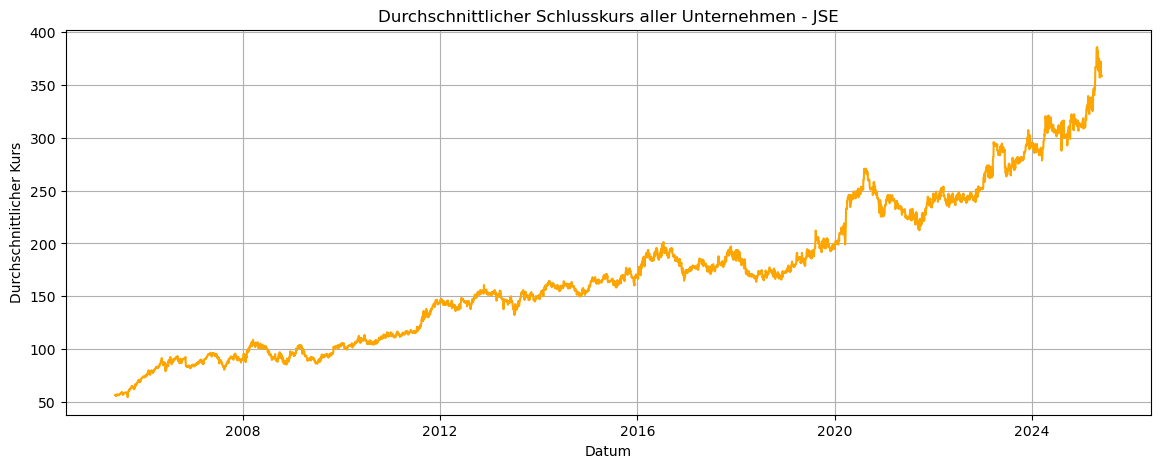

In [27]:
#Durchschnittlichen Kursverlauf der gesammelten Daten Darstellen - JSE

#Komma durch Punkt ersetzen und zu Zahlen konvertieren
df_JSE_bereinigt = df_JSEFinal.copy()

df_JSE_bereinigt = (
    df_JSE_bereinigt
    .astype(str)
    .replace(",", ".", regex=True)
    .apply(pd.to_numeric, errors='coerce')
)

#Problematischer Ticker, manche Kurse darin scheinen falsch ausgewiesen zu sein
#df_JSE_bereinigt = df_JSE_bereinigt.drop(columns=["RNG.JO"])

df_JSE_bereinigt["Durchschnitt"] = df_JSE_bereinigt.mean(axis=1, skipna=True)

# Plotten
plt.figure(figsize=(14, 5))
plt.plot(df_JSE_bereinigt.index, df_JSE_bereinigt["Durchschnitt"], color='orange', linewidth=1.5)
plt.title("Durchschnittlicher Schlusskurs aller Unternehmen - JSE")
plt.xlabel("Datum")
plt.ylabel("Durchschnittlicher Kurs")
plt.grid(True)
plt.show()

In [28]:
#Anzahl der Unternehmen, die in den jeweiligen Monaten gelistet waren (Werte verfügbar, JSE)

anzahl_kurse_jährlich_JSE = df_JSEFinal.resample('Y').count()
anzahl_gelistet_JSE = anzahl_kurse_jährlich_JSE.apply(lambda row: (row > 0).sum(), axis=1)

print(anzahl_gelistet_JSE)

Date
2005-12-31    147
2006-12-31    141
2007-12-31    155
2008-12-31    150
2009-12-31    148
2010-12-31    156
2011-12-31    157
2012-12-31    161
2013-12-31    163
2014-12-31    169
2015-12-31    169
2016-12-31    169
2017-12-31    176
2018-12-31    184
2019-12-31    185
2020-12-31    183
2021-12-31    190
2022-12-31    188
2023-12-31    191
2024-12-31    211
2025-12-31    214
Freq: A-DEC, dtype: int64


In [29]:
#Index in nur Jahr ändern
anzahl_gelistet_JSE.index = anzahl_gelistet_JSE.index.year

print(anzahl_gelistet_JSE)

Date
2005    147
2006    141
2007    155
2008    150
2009    148
2010    156
2011    157
2012    161
2013    163
2014    169
2015    169
2016    169
2017    176
2018    184
2019    185
2020    183
2021    190
2022    188
2023    191
2024    211
2025    214
dtype: int64


In [30]:
df_JSEFinal.to_csv("WhartonFinal_Neu.csv")

In [31]:
check = df_JSEFinal.pct_change()
check.to_csv("Wharton_Debug7.csv")